# Modelling the Non-Agentivity Alternation

In this notebook, the non-agentivity alternation is modelled as described in the doctoral thesis. Refer to the relevant chapter to understand modelling choices.

## Preparations

### Importing Relevant Libraries

In [1]:
library(lme4)
library(glue)
library(performance)
library(rstudioapi)
library(broom)
library(scales)
library(sjPlot)
library(ggplot2)
library(dplyr)
library(dplyr)
library(stargazer)
library(broom.mixed)

Lade nötiges Paket: Matrix

Learn more about sjPlot with 'browseVignettes("sjPlot")'.


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union



Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




### Loading and Preprocessing Data

Note that, as mentioned in the doctoral thesis, only data from the VACC corpus is used for modelling this alternation set.

In [2]:
data <- read.csv("VACC/NON-AGENTIVITY_for_modelling_VACC.csv")

Treatment coding of response variable: "man" = 0, "werden" = 1.

In [3]:
data$CURRENT <- as.factor(data$CURRENT)
cat("R models this level:", tail(levels(data$CURRENT), 1))

R models this level: werden

Renaming speakers for consistency with the rest of the thesis.

In [4]:
data <- data %>% mutate(PREVIOUS_SPEAKER = recode(PREVIOUS_SPEAKER, "A" = "VA", "S" = "HS", "J" = "CF"))

Combining the variables PREVIOUS and PREVIOUS_SPEAKER, as modelling an interaction of these two independent variables leads to an issue of singularity.

In [5]:
data$PREVIOUS_SPEAKER_COMBINED <- interaction(data$PREVIOUS, data$PREVIOUS_SPEAKER) #R automatically creates a factor
cat("Levels are:", levels(data$PREVIOUS_SPEAKER_COMBINED))

Levels are: man.CF werden.CF man.HS werden.HS man.VA werden.VA

`interaction()` also creates combinations which never appear. 

In [6]:
#discarding empty levels
data$PREVIOUS_SPEAKER_COMBINED <- droplevels(data$PREVIOUS_SPEAKER_COMBINED)

#before renaming (see above) "werden.A" was the reference level as it is first in alphabetical order, 
#to preserve this even after renaming, the factor is relevelled 
data$PREVIOUS_SPEAKER_COMBINED <- relevel(data$PREVIOUS_SPEAKER_COMBINED, ref = "werden.VA")
cat("The reference level of PREVIOUS_SPEAKER_COMBINED is:", head(levels(data$PREVIOUS_SPEAKER_COMBINED), 1)) 

The reference level of PREVIOUS_SPEAKER_COMBINED is: werden.VA

Treatment coding of further predictor variables.

In [7]:
data$PREVIOUS <- as.factor(data$PREVIOUS)
data$PREVIOUS_BETA_MAN <- as.factor(data$PREVIOUS_BETA_MAN) 
data$PREVIOUS_BETA_WERDEN <- as.factor(data$PREVIOUS_BETA_WERDEN) 

## Simple Model

### Model Fitting

In [8]:
simple_model <- glm(CURRENT ~ PREVIOUS_SPEAKER_COMBINED,
                                data = data, family = 'binomial')

summary(simple_model)


Call:
glm(formula = CURRENT ~ PREVIOUS_SPEAKER_COMBINED, family = "binomial", 
    data = data)

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)   
(Intercept)                          2.9444     1.0259   2.870  0.00410 **
PREVIOUS_SPEAKER_COMBINEDman.CF     -2.9444     1.0760  -2.736  0.00621 **
PREVIOUS_SPEAKER_COMBINEDwerden.CF   0.1911     1.4476   0.132  0.89500   
PREVIOUS_SPEAKER_COMBINEDman.HS     -3.1521     1.0918  -2.887  0.00389 **
PREVIOUS_SPEAKER_COMBINEDwerden.HS  -1.7768     1.0706  -1.660  0.09698 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 207.69  on 169  degrees of freedom
Residual deviance: 173.48  on 165  degrees of freedom
AIC: 183.48

Number of Fisher Scoring iterations: 5


### Model Evaluation

#### Events per Predictor

In [9]:
#Events per predictor
events <- sum(data$CURRENT == "man") #Number of positive cases
predictors <- length(coef(simple_model)) - 1 #Exclude intercept
EPP <- events / predictors
print(EPP)

[1] 12.75


#### R²

In [10]:
r2_nagelkerke(simple_model)

Nagelkerke's R2 
       0.258467

#### Predictive Efficiency

In [11]:
#Predictive efficiency
fixed_model_predictions <- predict(simple_model, newdata = data, type = "response")
#Convert probabilities to binary outcomes (i.e., if probability > 0.5, predict 1, else 0)
fixed_model_predicted_class <- ifelse(fixed_model_predictions > 0.5, "werden", "man")
#Compare predicted values to actual values
fixed_model_accuracy <- mean(fixed_model_predicted_class == data$CURRENT)
fixed_model_accuracy

[1] 0.7176471

In [12]:
#Calculate baseline accuracy, i.e., a dumb intercept-only model only ever predicting the most frequent outcome
counts <- table(data$CURRENT) 
dumb_model_accuracy <- max(counts) / sum(counts)
dumb_model_accuracy

[1] 0.7

In [13]:
#McNemar's Test for significance against baseline
baseline_predicted_class <- rep(names(which.max(counts)), length(data$CURRENT))  #Create baseline predictions (always predict the most frequent outcome)
mcnemar_table <- table(
  model_correct = (fixed_model_predicted_class == data$CURRENT),
  baseline_correct = (baseline_predicted_class == data$CURRENT)) #Create a contingency table: Compare model and baseline predictions against actual values
mcnemar_result <- mcnemar.test(mcnemar_table) #Perform McNemar's Test
mcnemar_result


	McNemar's Chi-squared test with continuity correction

data:  mcnemar_table
McNemar's chi-squared = 0.059701, df = 1, p-value = 0.807


### Visualisation

#### Coefficient Plot

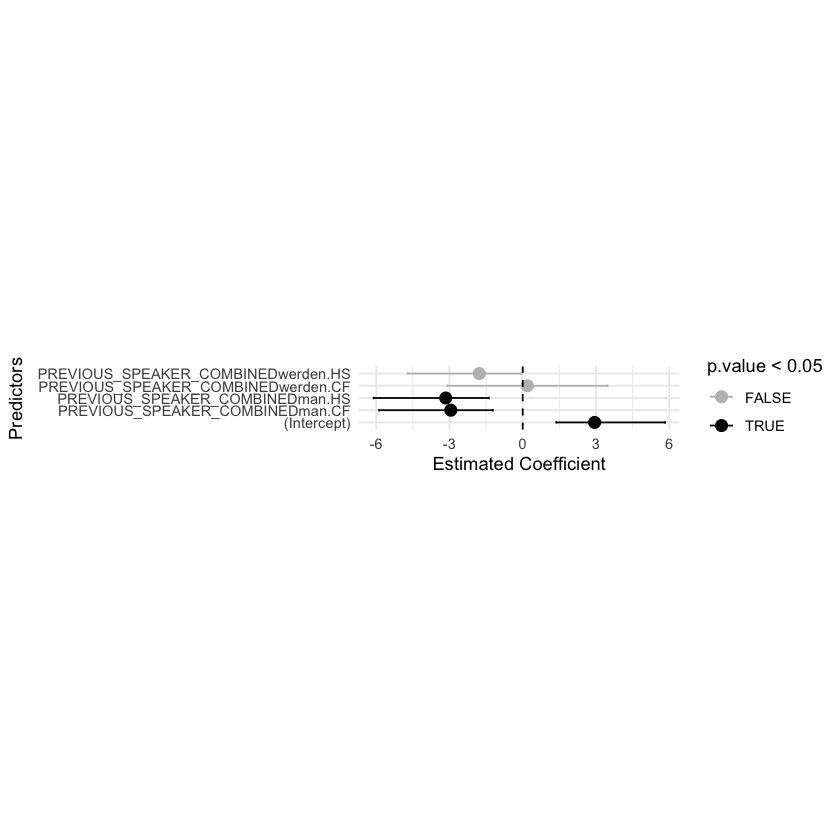

In [14]:
model_summary <- tidy(simple_model, conf.int = TRUE) 

plot <- ggplot(model_summary, aes(x = estimate, y = term, color = p.value < 0.05)) +
          geom_point(size = 3) +
                    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +
          geom_vline(xintercept = 0, linetype = "dashed") +
          labs(
            x = "Estimated Coefficient",
            y = "Predictors",
          ) +
          theme_minimal() +
          scale_color_manual(values = c("TRUE" = "black", "FALSE" = "gray")) +  #Grey out non-significant predictors
          coord_fixed(ratio = 0.5)

plot

#### Prediction Plot

Plot visualises the probability of observing "werden" in CURRENT given different combinations of variants in PREVIOUS and SPEAKERS.

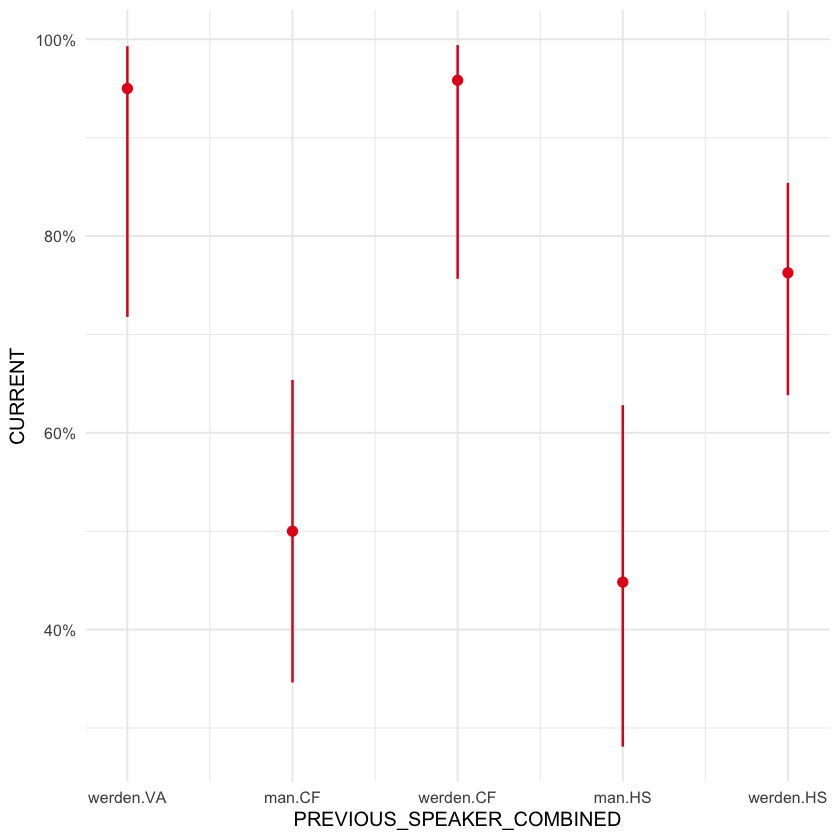

In [15]:
#for "werden" in CURRENT
plot <- plot_model(simple_model, type="pred", terms=c("PREVIOUS_SPEAKER_COMBINED"), dpi=300, ) + 
        theme(axis.text = element_text(size = 16), axis.title = element_text(size = 16)) + theme_minimal(base_size=12) +
        theme(plot.title = element_blank()) 

plot